In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seabornInstance 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
#from sklearn import datasets 
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import Imputer

### new ones
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Data Exploration
* We have one .csv file so we are going to load it to a pandas dataframe and explore the data. 

In [2]:
df=pd.read_csv('Data/Historical Product Demand.csv')

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
df.shape

(1048575, 5)

In [5]:
print(df.dtypes)

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object


In [6]:
len(df['Product_Category'].unique())

33

In [7]:
len(df['Product_Code'].unique())

2160

* From this we can conclude that in our products dataset we have 2160 different product and 33 different categories.


Now we will do exploratory data analysis on product category as it has fewer unique values

Text(0, 0.5, 'Frequency')

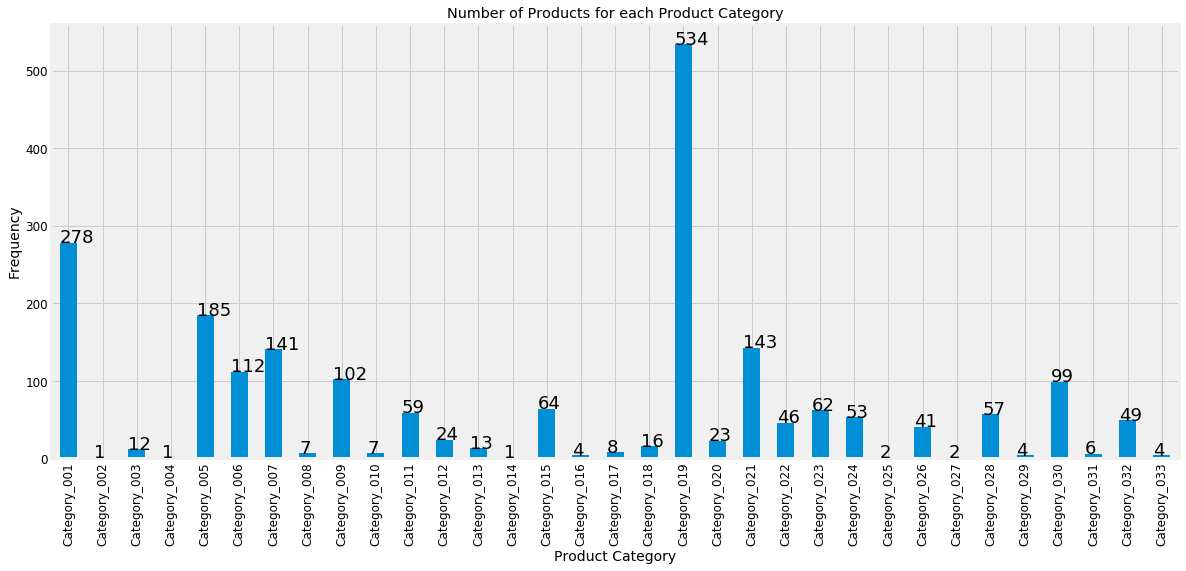

In [12]:

#Lets plot the no of products for each category
ax = df.groupby('Product_Category')['Product_Code'].nunique().plot(kind='bar',
                                    figsize=(18,8),
                                    title="Number of Products for each Product Category")

for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()), fontsize=18, color='black')
    
ax.set_xlabel("Product Category")
ax.set_ylabel("Frequency")

Now we will do exploratory data analysis on total demand per category

Text(0, 0.5, 'Demand')

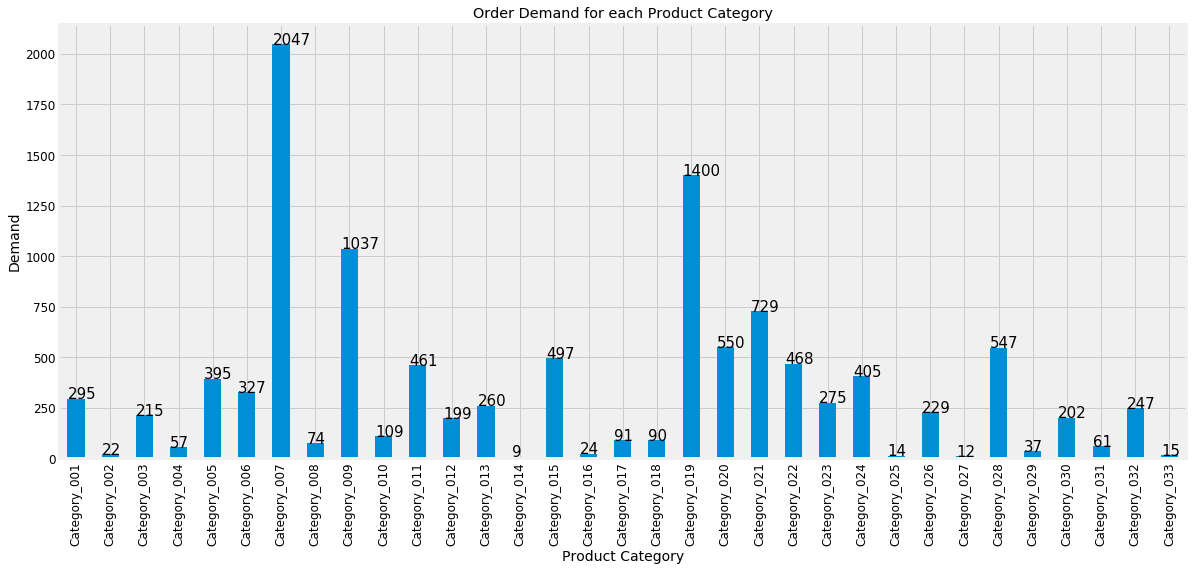

In [14]:
#Now lets plot the order_demand for each category
ax = df.groupby('Product_Category')['Order_Demand'].nunique().plot(kind='bar',
                                    figsize=(18,8),
                                    title="Order Demand for each Product Category")

for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()), fontsize=15, color='black')
    
ax.set_xlabel("Product Category")
ax.set_ylabel("Demand")

In [60]:
#Now lets check the frequency of products
product_count = df.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
product_count.head(10)

,Product_Code,counts
1348,Product_1359,16912
1284,Product_1295,10554
1367,Product_1378,9750
619,Product_0620,9404
1275,Product_1286,8874
1371,Product_1382,8607
1442,Product_1453,8490
1283,Product_1294,8365
1366,Product_1377,7857
1276,Product_1287,7817


#### Dates Range
* Now we would like to know the range of dates of these product orders. In order to do that we are going to use the following commands:

* By just looking at the first 5 rows it is clear that the dates are not sorted. So we have to sort the dates first in order to figure out the range of dates used for order delivery.

In [8]:
dates = [pd.to_datetime(date) for date in df['Date']]
dates.sort()

In [9]:
dates[0]

Timestamp('2011-01-08 00:00:00')

In [10]:
dates[-1]

Timestamp('2017-01-09 00:00:00')

* It is clear and now we can tell that the dates range from January 8th 2011 to January 9th 2017 which is approximately 6 years.

* Now we are going to convert the dataes to the standard datetime and drop null values using the following commands:

In [15]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.shape

(1037336, 5)

In [16]:
df.isnull().any()

Product_Code        False
Warehouse           False
Product_Category    False
Date                False
Order_Demand        False
dtype: bool

In [18]:
# def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
#     nunique = df.nunique()
#     df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
#     nRow, nCol = df.shape
#     columnNames = list(df)
#     nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
#     plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
#     for i in range(min(nCol, nGraphShown)):
#         plt.subplot(nGraphRow, nGraphPerRow, i + 1)
#         columnDf = df.iloc[:, i]
#         if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
#             valueCounts = columnDf.value_counts()
#             valueCounts.plot.bar()
#         else:
#             columnDf.hist()
#         plt.ylabel('counts')
#         plt.xticks(rotation = 90)
#         plt.title(f'{columnNames[i]} (column {i})')
#     plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
#     plt.show()

In [19]:
#plotPerColumnDistribution(df, 10, 5)

In [20]:
product_count = df.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
product_count.head(10)

,Product_Code,counts
1348,Product_1359,16936
1284,Product_1295,10575
1367,Product_1378,9770
619,Product_0620,9428
1275,Product_1286,8888
1371,Product_1382,8619
1442,Product_1453,8503
1283,Product_1294,8384
1366,Product_1377,7872
1276,Product_1287,7829


In [21]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [22]:
#newdf=df.groupby('Date')
#newdf['Order_Demand'].sum().reset_index()

In [23]:
#newdf = newdf[list(newdf.columns[~newdf.columns.duplicated()])]

In [24]:
df=df.set_index('Date')
df.index

DatetimeIndex(['2012-07-27', '2012-01-19', '2012-02-03', '2012-02-09',
               '2012-03-02', '2012-04-19', '2012-06-05', '2012-06-27',
               '2012-07-23', '2012-08-29',
               ...
               '2016-11-11', '2016-11-02', '2016-07-07', '2016-08-17',
               '2016-11-10', '2016-04-27', '2016-04-27', '2016-04-28',
               '2016-10-07', '2016-06-27'],
              dtype='datetime64[ns]', name='Date', length=1037336, freq=None)

In [25]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Order_Demand        object
dtype: object

In [26]:
#df['Order_Demand'].sum().reset_index()

* Now we will convert all the order demand column to numeric values.

In [27]:
df['Order_Demand']=pd.to_numeric(df['Order_Demand'],errors='coerce')

In [28]:
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100.0
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0


* Now we are going to remove null values in the 'Order_Demand' Column

In [29]:
df.dropna(subset=['Order_Demand'],inplace=True)

In [30]:
df.isnull().any()

Product_Code        False
Warehouse           False
Product_Category    False
Order_Demand        False
dtype: bool

* We will use the average daily order demands per month since we have a lot of data

In [37]:
y =df['Order_Demand']

In [38]:
print(type(y))

<class 'pandas.core.series.Series'>


In [39]:
y.dropna(inplace=True)

In [40]:
y['2015':]

Date
2015-01-05       600.0
2015-01-05       200.0
2015-01-05     75000.0
2015-01-05      1000.0
2015-01-05    100000.0
2015-01-01     25000.0
2015-01-01      3000.0
2015-01-01     90000.0
2015-01-01     15000.0
2015-01-01    204500.0
2015-01-01     32000.0
2015-01-01      9500.0
2015-01-01     22000.0
2015-01-01       400.0
2015-01-05      4000.0
2015-01-05      1000.0
2015-01-05      2000.0
2015-01-06     10000.0
2015-01-05      1000.0
2015-01-06      5000.0
2015-01-06      9000.0
2015-01-05      1000.0
2015-01-05      1000.0
2015-01-05      1000.0
2015-01-07      2000.0
2015-01-07      2000.0
2015-01-09     10000.0
2015-01-07         8.0
2015-01-01       400.0
2015-01-01       800.0
                ...   
2016-05-20        25.0
2016-05-25        10.0
2016-07-07        24.0
2016-08-17        30.0
2016-08-17        30.0
2016-08-17        30.0
2016-10-06         6.0
2016-10-06       180.0
2016-10-06        26.0
2016-10-06        98.0
2016-10-06       116.0
2016-11-02       480.0
2016-1

### Visualizing Order Demands Time Series Data

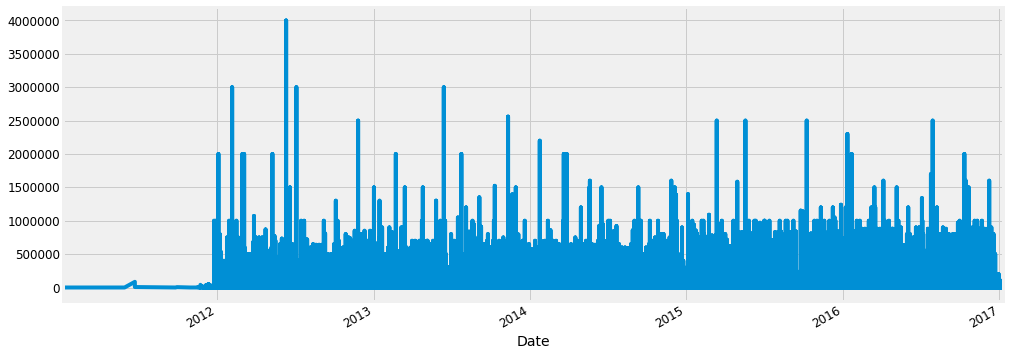

In [41]:
y.plot(figsize=(15,6))

### Observation
* We can observe that there are some trends in the data and theree are peaks normally at the first months of a year.

* We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

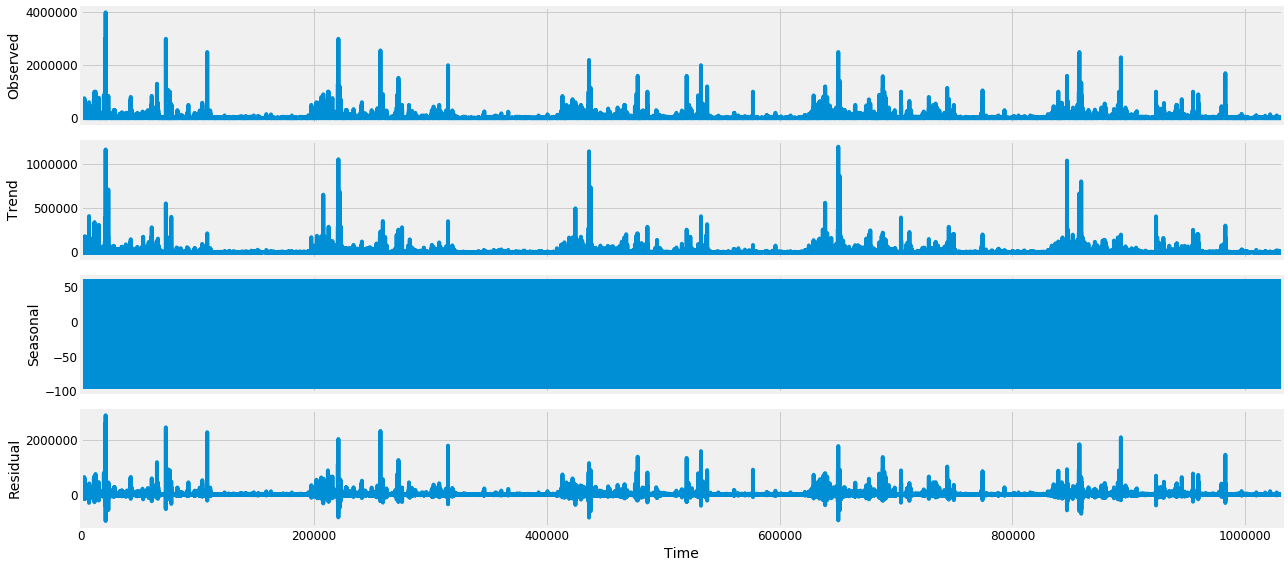

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y.values,freq=12, model='additive')
fig = decomposition.plot()
plt.show()

## Time Series Forecasting with ARIMA

* We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

* ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [45]:
y =df['Order_Demand'].resample('MS').mean()

In [46]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


* This step is parameter Selection for our Order Demand ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [47]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1389.1733613820293
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1179.5884166498581
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1211.357691561787
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:715.9346070295747
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1180.0525786807389
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1164.2052841900002
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:730.3071278209837
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:716.8603070311083
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1357.6948086895377
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1092.4871162645616
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1192.1940334157237
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:698.4552172692462
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1135.0020066960328
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1094.032133158191
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:732.296163722434
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:700.6273428301278
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1374.2547065072363
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:876.9328361023929
AR

### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 698.33. Therefore we should consider this to be optimal option.

In [48]:
mod = sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3384      0.169     -2.007      0.045      -0.669      -0.008
ma.L1         -0.0765      0.117     -0.652      0.514      -0.306       0.153
ar.S.L12      -0.0036      0.011     -0.327      0.743      -0.025       0.018
sigma2      1.861e+05   4.97e+04      3.746      0.000    8.87e+04    2.83e+05


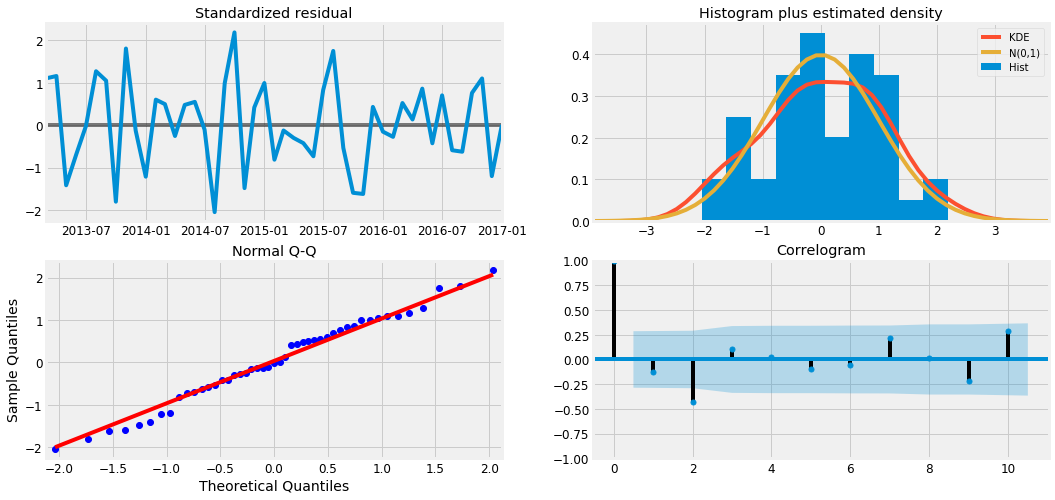

In [49]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [56]:
y =df['Order_Demand'].resample('MS').mean()

In [57]:
y_forecasted = pred.predicted_mean
y_truth = y[5:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 9.23


In [58]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3.04


### Forecasting using FBprophet

* In this part we are going to take one product and do time forecasting on it. Since product product_1295 has the second highest count we are going to do time forecasting on it.

In [82]:
df=pd.read_csv('Data/Historical Product Demand.csv')

In [83]:
#Create a new data frame with only product_code 1295
product_1295 = df.loc[df['Product_Code'] == 'Product_1295']
product_1295.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
5787,Product_1295,Whse_J,Category_019,2012/1/23,50000
5788,Product_1295,Whse_J,Category_019,2012/2/8,50000
5789,Product_1295,Whse_J,Category_019,2012/3/8,50000
5790,Product_1295,Whse_J,Category_019,2012/3/26,50000
5791,Product_1295,Whse_J,Category_019,2012/4/26,50000


In [84]:
product_1295 = product_1295.drop(columns=["Warehouse", "Product_Code", "Product_Category"])
product_1295.head()

,Date,Order_Demand
5787,2012/1/23,50000
5788,2012/2/8,50000
5789,2012/3/8,50000
5790,2012/3/26,50000
5791,2012/4/26,50000


In [85]:
#Convert the "Date" to date format
product_1295.loc[:, 'Date'] = pd.to_datetime(product_1295.loc[:,'Date'], format="%Y/%m/%d")
product_1295.describe()

,Date,Order_Demand
count,10575,10575
unique,1217,218
top,2014-09-18 00:00:00,10000
freq,33,2350
first,2012-01-05 00:00:00,NaN
last,2016-12-28 00:00:00,NaN


In [86]:
#Indexing with timeseries data
product_1295=product_1295.set_index('Date')
product_1295.index

DatetimeIndex(['2012-01-23', '2012-02-08', '2012-03-08', '2012-03-26',
               '2012-04-26', '2012-05-08', '2012-07-03', '2012-08-03',
               '2012-08-30', '2012-09-20',
               ...
               '2016-01-18', '2016-01-22', '2016-01-27', '2016-02-26',
               '2016-03-01', '2016-05-02', '2016-06-01', '2016-09-20',
               '2016-10-17', '2016-01-13'],
              dtype='datetime64[ns]', name='Date', length=10575, freq=None)

In [87]:
product_1295['Order_Demand'] = product_1295['Order_Demand'].astype(str)
product_1295['Order_Demand'] = product_1295['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
product_1295['Order_Demand'] = product_1295['Order_Demand'].astype(int)


In [88]:
#Calculating sum of order demand on per month basis
product_1295_Month = product_1295["Order_Demand"].resample('MS').sum()
product_1295_Month['2015':]

Date
2015-01-01    2329300
2015-02-01    1993400
2015-03-01    2482700
2015-04-01    2346500
2015-05-01    1878500
2015-06-01    2235500
2015-07-01    2878300
2015-08-01    1888600
2015-09-01    1974200
2015-10-01    2093300
2015-11-01    2022300
2015-12-01    2119500
2016-01-01    1923500
2016-02-01    1865900
2016-03-01    2651600
2016-04-01    2540700
2016-05-01    1761100
2016-06-01    2356300
2016-07-01    1916700
2016-08-01    2058200
2016-09-01    2119200
2016-10-01    2251900
2016-11-01    2522400
2016-12-01    2543400
Freq: MS, Name: Order_Demand, dtype: int32

#### Visualizing Demand Time Series Data

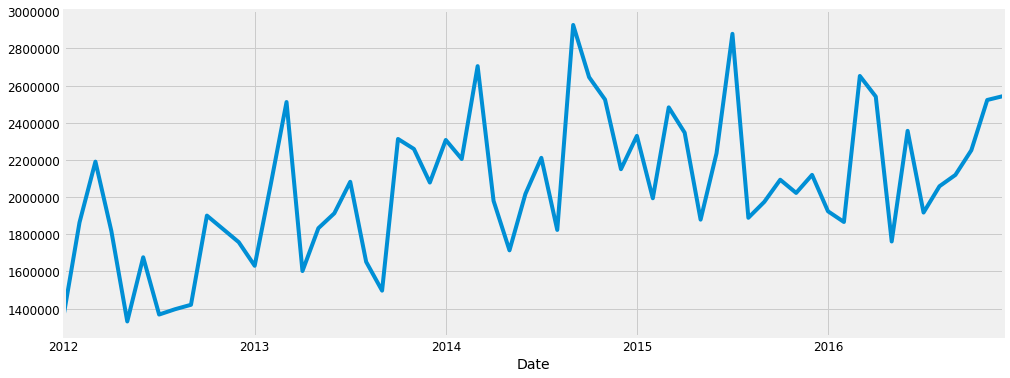

In [91]:

product_1295_Month.plot(figsize=(15, 6))
plt.show()

#### Time Forecasting

In [94]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [92]:
#reference : https://facebook.github.io/prophet/docs/quick_start.html#python-api 
product_1295 = pd.DataFrame({'Date':product_1295_Month.index, 'Order_Demand':product_1295_Month.values})
product_1295.columns = ['ds', 'y']
product_1295.head()

,ds,y
0,2012-01-01,1360800
1,2012-02-01,1863200
2,2012-03-01,2190800
3,2012-04-01,1817400
4,2012-05-01,1330700


In [93]:
model = Prophet(interval_width=0.95, weekly_seasonality=True)
model.fit(product_1295)

NameError: name 'Prophet' is not defined